<a href="https://colab.research.google.com/github/silencer722/digit-classifier/blob/main/digit_class.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torch torchvision torchaudio
!pip install -q scikit-learn matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 27.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 26.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.7/188.7 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 77.7 MB/s eta 0:00:00


In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

print(torch.__version__, torchvision.__version__)


2.6.0+cu124 0.21.0+cu124


In [2]:
train_ds = datasets.MNIST(root="./data", train=True, download=True)
test_ds  = datasets.MNIST(root="./data", train=False, download=True)

print(len(train_ds), len(test_ds))


100%|██████████| 9.91M/9.91M [00:00<00:00, 123MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 27.8MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 93.4MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.49MB/s]

60000 10000


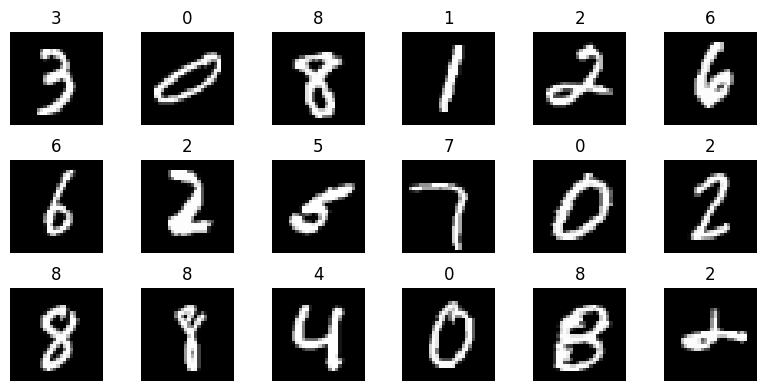

In [3]:
import numpy as np

fig, axes = plt.subplots(3, 6, figsize=(8,4))
for ax in axes.ravel():
    i = np.random.randint(0, len(train_ds))
    img, label = train_ds[i]
    ax.imshow(img, cmap="gray")
    ax.set_title(label)
    ax.axis("off")
plt.tight_layout()


In [4]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=64, shuffle=False)


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim

model = nn.Sequential(
    nn.Flatten(),              # (1,28,28) -> (784,)
    nn.Linear(28*28, 10)       # 784 inputs -> 10 outputs (digits 0–9)
)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)


In [6]:
from torchvision import transforms

transform = transforms.ToTensor()
train_ds.transform = transform
test_ds.transform  = transform

# then recreate loaders
train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)


In [7]:
for epoch in range(5):  # train for 5 epochs
    for images, labels in train_loader:
        # forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)

        # backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item():.4f}")


Epoch 1, Loss: 0.2238
Epoch 2, Loss: 0.3003
Epoch 3, Loss: 0.6216
Epoch 4, Loss: 0.1707
Epoch 5, Loss: 0.1116


In [15]:
plt.plot(range(1, len(last_batch_losses)+1), last_batch_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Last batch loss")
plt.show()

NameError: name 'last_batch_losses' is not defined

In [8]:
# put model in eval mode and compute accuracy on test_loader
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

print(f"Test accuracy: {100 * correct / total:.2f}%")


Test accuracy: 92.03%


In [9]:
# compute training accuracy (may be slow for full train set but OK)
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for images, labels in train_loader:
        outputs = model(images)
        _, preds = outputs.max(1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()
print(f"Train accuracy: {100 * correct / total:.2f}%")


Train accuracy: 91.99%


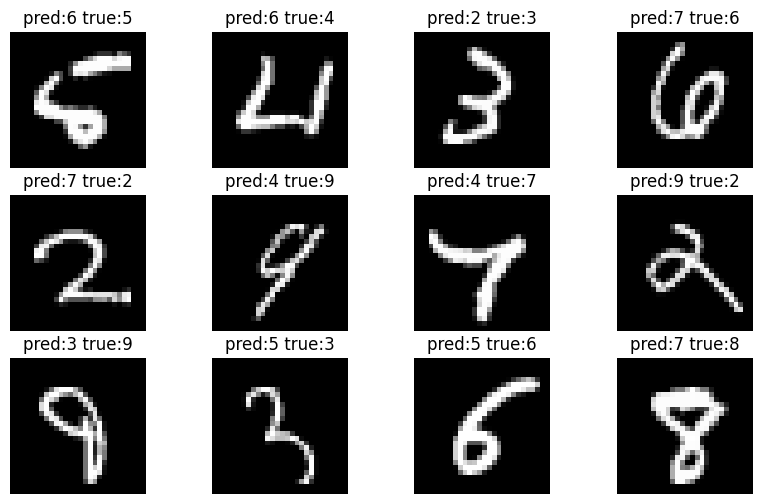

In [10]:
misclassified = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images)
        _, preds = outputs.max(1)
        mask = preds != labels
        for img, p, t in zip(images[mask], preds[mask], labels[mask]):
            misclassified.append((img.cpu(), p.item(), t.item()))
            if len(misclassified) >= 12:
                break
        if len(misclassified) >= 12:
            break

import matplotlib.pyplot as plt
fig, axes = plt.subplots(3, 4, figsize=(10,6))
for ax, (img, p, t) in zip(axes.ravel(), misclassified):
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"pred:{p} true:{t}")
    ax.axis('off')
plt.show()


In [11]:
torch.save(model.state_dict(), "mnist_logreg.pth")
# to load later:
# model.load_state_dict(torch.load("mnist_logreg.pth"))


Epoch 1, Loss: 0.2889
Epoch 2, Loss: 0.2844
Epoch 3, Loss: 0.2807
Epoch 4, Loss: 0.2783
Epoch 5, Loss: 0.2758


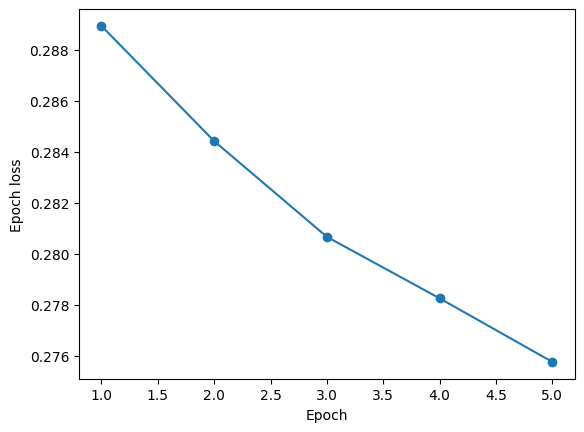

In [12]:
train_losses = []
for epoch in range(5):
    running_loss = 0.0
    for images, labels in train_loader:
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)   # accumulate total loss

    epoch_loss = running_loss / len(train_loader.dataset)
    train_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}, Loss: {epoch_loss:.4f}")

# plot
import matplotlib.pyplot as plt
plt.plot(range(1, len(train_losses)+1), train_losses, marker='o')
plt.xlabel("Epoch")
plt.ylabel("Epoch loss")
plt.show()


In [13]:
model = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 128),
    nn.ReLU(),
    nn.Linear(128, 10)
)
optimizer = optim.Adam(model.parameters(), lr=1e-3)


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
# inside training loop:
images, labels = images.to(device), labels.to(device)
